# Cálculo de CFR para microorganismos selectos

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

from keras.wrappers.scikit_learn import KerasRegressor

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd
import re
import tqdm
from google.colab import files

## Carga de datos de resistencia

In [ ]:
df = pd.read_csv('VAN_EUCAST_distribution.csv')

In [ ]:
df.head()

,Bacteria,0.002,0.004,0.008,0.016,0.03,0.06,0.125,0.25,0.5,...,8,16,32,64,128,256,512,Distributions,Observations,ECOFF
0,Aerococcus spp,0,0,0,0,0,0,0,25,35,...,0,0,0,0,0,0,0,1,60,-
1,Aerococcus urinae,0,0,0,0,0,0,0,2,28,...,0,0,0,0,0,0,0,1,30,-
2,Bifidobacterium longum,0,0,0,0,0,0,0,4,60,...,0,0,0,0,0,0,0,1,79,-
3,Bifidobacterium pseudolongum,0,0,0,0,0,0,0,2,79,...,0,0,0,0,0,0,0,1,82,-
4,Bifidobacterium spp,0,0,0,0,0,0,0,12,275,...,0,0,0,0,0,0,0,2,364,-


In [ ]:
df.Bacteria.unique()

array(['Aerococcus spp', 'Aerococcus urinae', 'Bifidobacterium longum',
       'Bifidobacterium pseudolongum', 'Bifidobacterium spp',
       'Bifidobacterium thermophilum', 'Clostridium difficile',
       'Corynebacterium amycolatum', 'Corynebacterium jeikeium',
       'Corynebacterium spp', 'Corynebacterium striatum',
       'Corynebacterium urealyticum', 'Cutibacterium acnes',
       'Enterococcus faecalis', 'Enterococcus faecium',
       'Enterococcus spp', 'Lactobacillus acidophilus',
       'Lactobacillus amylovorus', 'Lactobacillus crispatus',
       'Lactobacillus delbrueckii', 'Lactobacillus gallinarum',
       'Lactobacillus gasseri', 'Lactobacillus helveticus',
       'Lactobacillus johnsonii', 'Lactobacillus lactis',
       'Lactobacillus reuteri', 'Lactococcus lactis',
       'Listeria monocytogenes', 'Staphylococcus aureus',
       'Staphylococcus aureus MRSA', 'Staphylococcus aureus MSSA',
       'Staphylococcus capitis', 'Staphylococcus coagulase negative',
       'Staph

In [ ]:
bacterias_seleccionadas = ['Staphylococcus aureus', 'Staphylococcus coagulase negative', 'Staphylococcus epidermidis', 'Staphylococcus haemolyticus', 'Enterococcus faecalis', 'Enterococcus faecium']

dfselected = df.loc[df.Bacteria.isin(bacterias_seleccionadas),:]

dfselected

,Bacteria,0.002,0.004,0.008,0.016,0.03,0.06,0.125,0.25,0.5,...,8,16,32,64,128,256,512,Distributions,Observations,ECOFF
13,Enterococcus faecalis,0,0,0,0,0,0,2,31,457,...,26,7,145,4,22,34,8,38,14998,4
14,Enterococcus faecium,0,0,0,0,0,0,1,43,1115,...,25,7,5,22,12,193,4,22,4360,4
28,Staphylococcus aureus,0,0,0,0,0,1,69,539,13997,...,3,0,1,1,1,0,0,39,91876,2
32,Staphylococcus coagulase negative,0,0,0,0,0,0,12,69,595,...,6,2,0,0,0,0,0,11,12134,4
35,Staphylococcus epidermidis,0,0,0,0,0,0,3,27,402,...,2,0,0,0,0,0,0,13,15096,4
37,Staphylococcus haemolyticus,0,0,0,0,0,0,0,11,178,...,0,1,0,0,0,0,0,12,2168,4


In [ ]:
df2 = pd.melt(dfselected, 
        id_vars = ['Bacteria'],
        value_vars=[i for i in dfselected.columns if re.match(r'^\d', i) is not None], 
        var_name = 'MIC', value_name = 'Conteo')

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


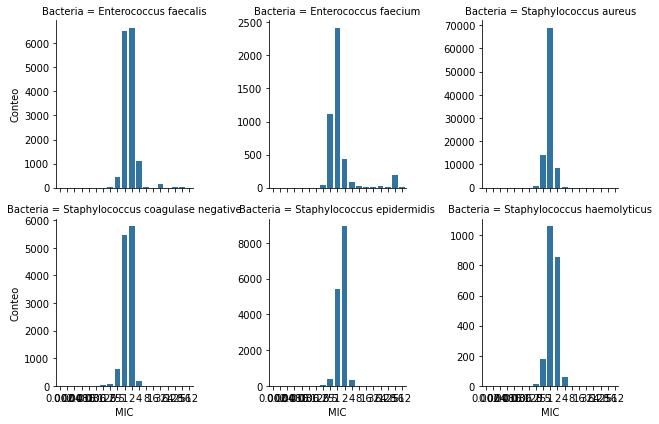

In [ ]:
g = sns.FacetGrid(df2, col="Bacteria", col_wrap=3, sharey=False)
g.map(sns.barplot, "MIC", 'Conteo')

## **Apertura de modelo Keras**

In [ ]:
! unzip -q model_001.zip -d model_001/

In [ ]:
from tensorflow import keras
model = keras.models.load_model('model_001')

In [ ]:
ordenLista = ['DD', 'II', 'Tinf', 'CLCR', 'MIC']

x= model.predict([[2000, 12, 2, 100, -1]])
x[0][0]

0.9999057

In [ ]:
df2['logMIC'] = df2.MIC.apply(lambda x: np.log2(float(x)))
df2['Prop']   = df2.groupby('Bacteria', group_keys=False).apply(lambda x: x.Conteo/sum(x.Conteo))
df2

,Bacteria,MIC,Conteo,logMIC,Prop
0,Enterococcus faecalis,0.002,0,-8.965784,0.000000
1,Enterococcus faecium,0.002,0,-8.965784,0.000000
2,Staphylococcus aureus,0.002,0,-8.965784,0.000000
3,Staphylococcus coagulase negative,0.002,0,-8.965784,0.000000
4,Staphylococcus epidermidis,0.002,0,-8.965784,0.000000
...,...,...,...,...,...
109,Enterococcus faecium,512,4,9.000000,0.000917
110,Staphylococcus aureus,512,0,9.000000,0.000000
111,Staphylococcus coagulase negative,512,0,9.000000,0.000000
112,Staphylococcus epidermidis,512,0,9.000000,0.000000


In [ ]:
df2['CFR_i'] = [i for i in map(lambda x,y: y * model.predict([[2000, 12, 2, 100, x]])[0][0], df2.logMIC, df2.Prop)]

In [ ]:
df2.groupby('Bacteria').apply(lambda x: np.sum(x.CFR_i))

Bacteria
Enterococcus faecalis                0.386730
Enterococcus faecium                 0.712117
Staphylococcus aureus                0.762023
Staphylococcus coagulase negative    0.423742
Staphylococcus epidermidis           0.322410
Staphylococcus haemolyticus          0.484200
dtype: float64

## **Ejecutar cálculo de CFR para varios regímenes de administración**

In [ ]:
# Se simulan varios regímenes de dosificación
dataADM = pd.DataFrame(
    [[1500, 12, 2,  80],
     [1500, 12, 2,  100],
     [1500, 12, 2,  120],
     [1500, 12, 2,  140],
     [2000, 12, 2,  80],
     [2000, 12, 2,  100],
     [2000, 12, 2,  120],
     [2000, 12, 2,  140],
     [2500, 12, 2,  80],
     [2500, 12, 2,  100],
     [2500, 12, 2,  120],
     [2500, 12, 2,  140],
     [3000, 12, 2,  80],
     [3000, 12, 2,  100],
     [3000, 12, 2,  120],
     [3000, 12, 2,  140]],
     columns = ['DD', 'II', 'Tinf', 'CrCl'], dtype = float
)

# dataADM.head(3)
dataADM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DD      16 non-null     float64
 1   II      16 non-null     float64
 2   Tinf    16 non-null     float64
 3   CrCl    16 non-null     float64
dtypes: float64(4)
memory usage: 640.0 bytes


In [ ]:
CFR_ls = list()

for index, row in tqdm.tqdm(dataADM.iterrows()):
  df2['CFR_i'] = [i for i in map(lambda x,y: y * model.predict([[row['DD'], row['II'], row['Tinf'], row['CrCl'], x]])[0][0], df2.logMIC, df2.Prop)]
  x = df2.groupby('Bacteria').apply(lambda x: np.sum(x.CFR_i))
  # print(row['DD'], row['II'])
  CFR_ls.append(x)

16it [02:07,  7.97s/it]


In [ ]:
#[[1000, 12, 2, 100, 2]]

df3 = pd.concat([dataADM.copy(), pd.DataFrame(columns = CFR_ls[1].index)])

for index, row in tqdm.tqdm(dataADM.iterrows()):
  df3.iloc[index, 4:10] = np.transpose(CFR_ls[index])

df3.to_csv('100_indicadorAUC_MIC.csv')
files.download('/content/100_indicadorAUC_MIC.csv')

16it [00:00, 594.82it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>